# **Simple Human Onchocerciasis Modelling**

This notebook explores a simple deterministic human onchocerciasis model defined as a system of differential equations. The model was developed by Basáñez & Boussinesq (1999) and the paper defining the derivation of equations and parameters can be found here: https://royalsocietypublishing.org/doi/10.1098/rstb.1999.0433.

In [3]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint, solve_ivp

np.set_printoptions(precision = 2, suppress = True)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

COLORS = {"W": "#2f4b7c",
          "M": "#ffa600",
          "L": "#f95d6a",
          "P": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

%load_ext watermark
%watermark --iversions -v -a "Kojo Nketia" -gu "kojonketia"

Author: Kojo Nketia

Github username: kojonketia

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

seaborn   : 0.13.2
matplotlib: 3.8.4
pandas    : 1.5.3
json      : 2.0.9
numpy     : 1.26.4



## Setting and definining parameters

In [5]:
# INPUT

# Initial values for state variables: we commence with 10 adult worms
initial_state_values = [10,  # W - mean number of adult worms per person at time 0
                        0,   # M - mean number of Mf per milligram per person at time 0
                        0,   # L - mean number of infective larvae (L3) per fly at time 0
                        0,   # P - microfilarial prevalence output
                        0]   # ATP - annual transmission potential 

# Parameter values (values are expressed per year)
# Average values taken from Table 2 Basáñez & Boussinesq (1999)
aH = 0.8
sH = 0.2    
aV = 0.4481    
sV0 = 0.0463
c = 0.0196
alpha = 0.8653
h = 0.3
g = 0.0096      
  
parameters = [aH,         # aH
              sH,         # sH
              aV,         # aV
              sV0,        # sV0
              c,          # c
              alpha,      # alpha
              h,          # h      
              g,          # g   
              aH*sH,      # deltaH0
              0.0032,     # deltaHinfiniry
              0.0137,     # cH
              0.02,       # muH
              0.1,        # sigmaW
              0.8,        # sigmaM
              104,        # sigmaL
              1,          # phi
              0.6674,     # F 
              0.0553,     # k0
              0.491,      # k1
              aV*sV0,     # deltaV0
              aV*c,       # cV0    
              aV*alpha,   # alphaV 
              h/g,        # beta
              52,         # muV  
              1000]       # ABR

'''
Parameters can also be defined as a dictionary
'''

'\nParameters can also be defined as a dictionary\n'

For more about parameter definitions, check the <span style="color: blue">ReadME</span> file and/or check the paper above.

## Defining the onchocerciasis differential equation as a function

The human onchocerciasis differential equations are defined as

\begin{align}
\dfrac{dW(t)}{dt} &= \frac{V}{H}\beta\left(\dfrac{\delta_{H_{0}}+\delta_{H_{\infty}}c_{H_{i}}(V/H)\beta L(t)}{1+c_{H_{i}}(V/H)\beta L(t)}\right)L(t)-(\sigma_{W}+\mu_{H})W(t)  \\ \\
\dfrac{dM(t)}{dt} &= \left(\frac{1}{2}\phi F\right)W(t)-(\sigma_{M}+\mu_{H})M(t) \\ \\
\dfrac{dL(t)}{dt} &= \beta\left(\dfrac{\delta_{V_{0}}}{1+c_{v}M(t)}\right) - \left(\sigma_{L}+\mu_{V}+\alpha_{V}M(t)\frac{a_{H}}{g}\right)L(t)
\end{align}

The prevalence $(p)$ is calculated by the formula below \n
\begin{equation}
p= 100\left[1-\left(1+\frac{M}{k_{0}M^{k_{1}}}\right)^{-k_{0}M^{k_{1}}}\right] 
\end{equation}

where $W(t), M(t)$ and $L(t)$ refers to the worm, microfilariae and larvae dynamics respectively.

In [9]:
# Simulate model for 300 years, in 0.1 year intervals
timestep = 0.1
times = np.arange(0, 300, timestep)

# ONCHO MODEL FUNCTION
def oncho_model(state, time, parameters):
    W, M, L, P, ATP = state
    aH, sH, aV, sV0, c, alpha, h, g, deltaH0, deltaHinfinity, cH, muH, sigmaW, sigmaM, sigmaL, phi, F, k0, k1, deltaV0, cV0, alphaV, beta, muV, ABR = parameters
    
    # Differential equations
    dW = ((deltaH0 + deltaHinfinity * cH * ABR * L)/(1 + cH * ABR * L)) * ABR * L - (sigmaW + muH) * W
    dM = ((1/2) * phi * F) * W - (sigmaM + muH) * M
    dL = (deltaV0/(1 + cV0 * M)) * beta * M - (sigmaL + muV + alphaV * M + (aH/g)) * L
    
    # Microfilarial prevalence (in %)
    P = 100 * (1 - (1 + M/(k0*M**k1))**(-k0*M**k1)) 
    # ATP
    ATP = ABR * dL
    
    # Output
    return [dW, dM, dL, P, ATP]


## Solving the ODE

In [11]:
# Solve the equations
output = odeint(oncho_model, initial_state_values, times, args=(parameters,))

C:\Users\User\AppData\Local\Temp\ipykernel_25052\2073259443.py:16: RuntimeWarning: invalid value encountered in scalar divide
  P = 100 * (1 - (1 + M/(k0*M**k1))**(-k0*M**k1))


In [12]:
# Add time to array
output = np.c_[times, output]

# Convert the output to a DataFrame
output_df = pd.DataFrame(output, columns=['time','W', 'M', 'L', 'P', 'ATP'])
output_df['MFP'] = output_df['P'].diff() / timestep
output_df['MFP'].iloc[0] = output_df['P'].iloc[0]


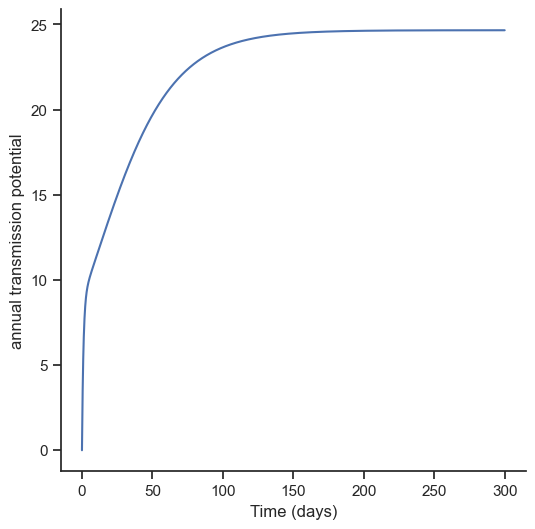

In [26]:
# OUTPUT
output_df.tail()

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(output_df['time'], output_df['ATP']);
ax.set(xlabel = "Time (days)", ylabel = "annual transmission potential");

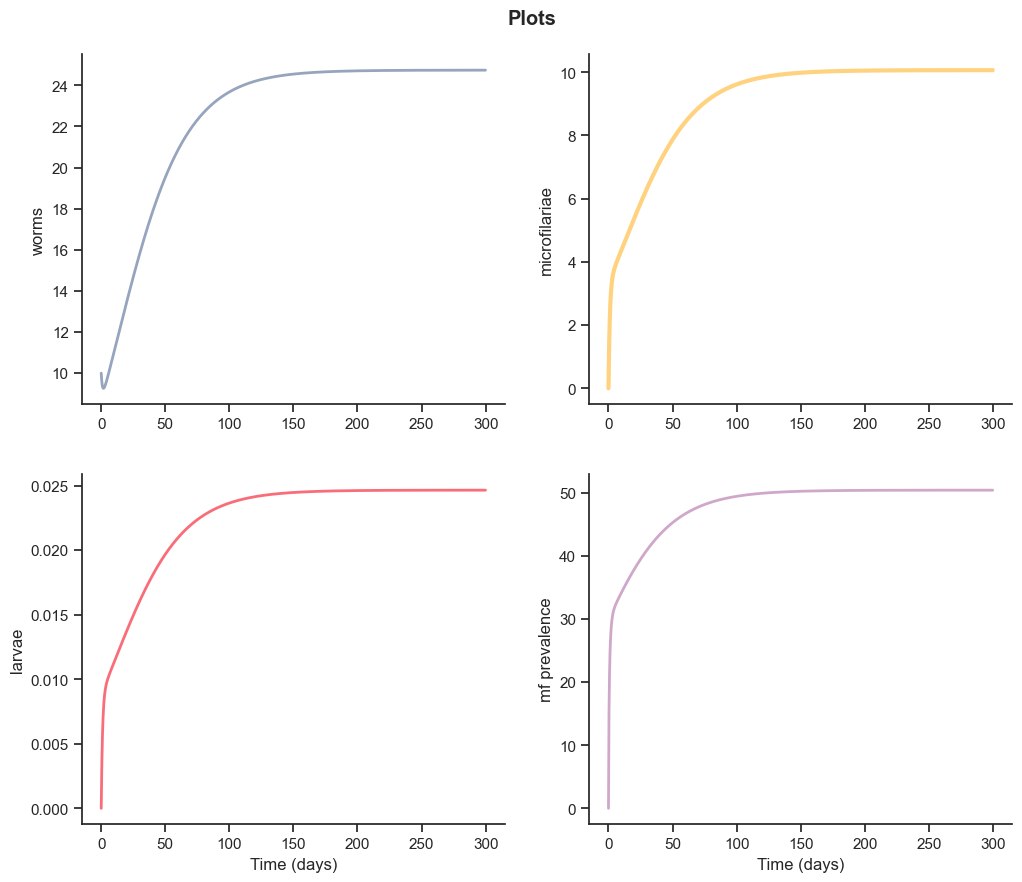

In [14]:
# We obtain each column by transposing then indexing (as Numpy indexes by default in rows)

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221, axisbelow=True)
ax1.plot(output_df['time'], output_df['W'], color=COLORS["W"], alpha=0.5, lw=2, label="Worm")
ax1.set(ylabel = "worms")

ax2 = fig.add_subplot(222, axisbelow=True)
ax2.plot(output_df['time'], output_df['M'], color=COLORS["M"], alpha=0.5, lw=3, label="Microfilariae")
ax2.set(ylabel = "microfilariae")

ax3 = fig.add_subplot(223, axisbelow=True)
ax3.plot(output_df['time'], output_df['L'], color=COLORS["L"], alpha=0.9, lw=2, label="Larvae")
ax3.set(xlabel ='Time (days)', ylabel = "larvae")

ax4 = fig.add_subplot(224, axisbelow=True)
ax4.plot(output_df['time'], output_df['MFP'], color=COLORS["P"], alpha=0.5, lw=2, label="Worm")
ax4.set(xlabel ='Time (days)', ylabel = "mf prevalence")

fig.suptitle("Plots", weight = "bold", y = 0.925)

plt.show()
